In [37]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-06 15:46:36,113 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize()

In [3]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020']).filter_within_geometry(sierras)

In [4]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-06 15:29:25,233 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-06 15:29:26,011 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-06 15:29:28,396 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-06 15:29:29,164 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-06 15:29:29,611 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [5]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-06 15:35:16,244 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-06 15:35:17,670 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-06 15:35:23,345 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-06 15:35:25,623 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-06 15:35:26,616 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [6]:
creek_fire = sierra_firep.get_fire('CREEK')

In [10]:
matches = gedi_matching.match_measurements_before_and_after_fire(creek_fire, gedi_burned, 'agbd')

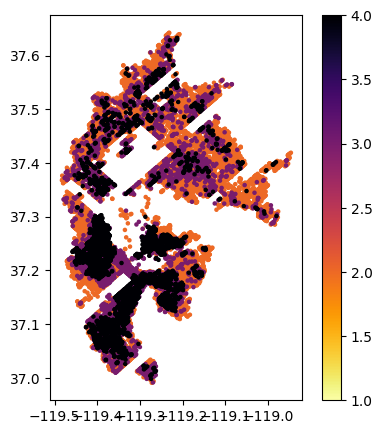

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

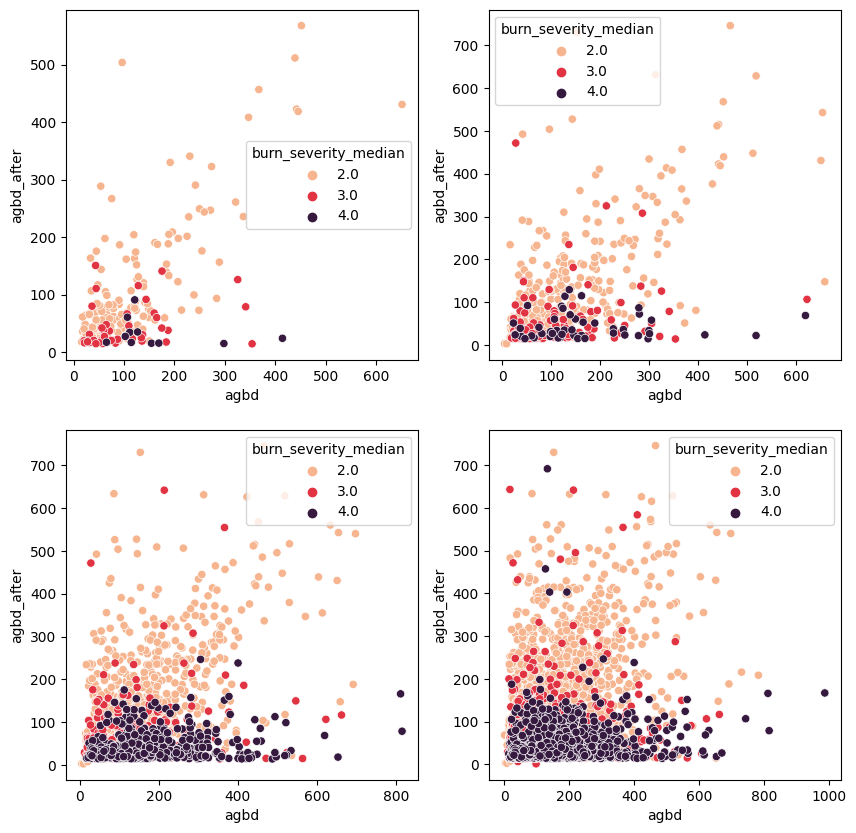

In [12]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


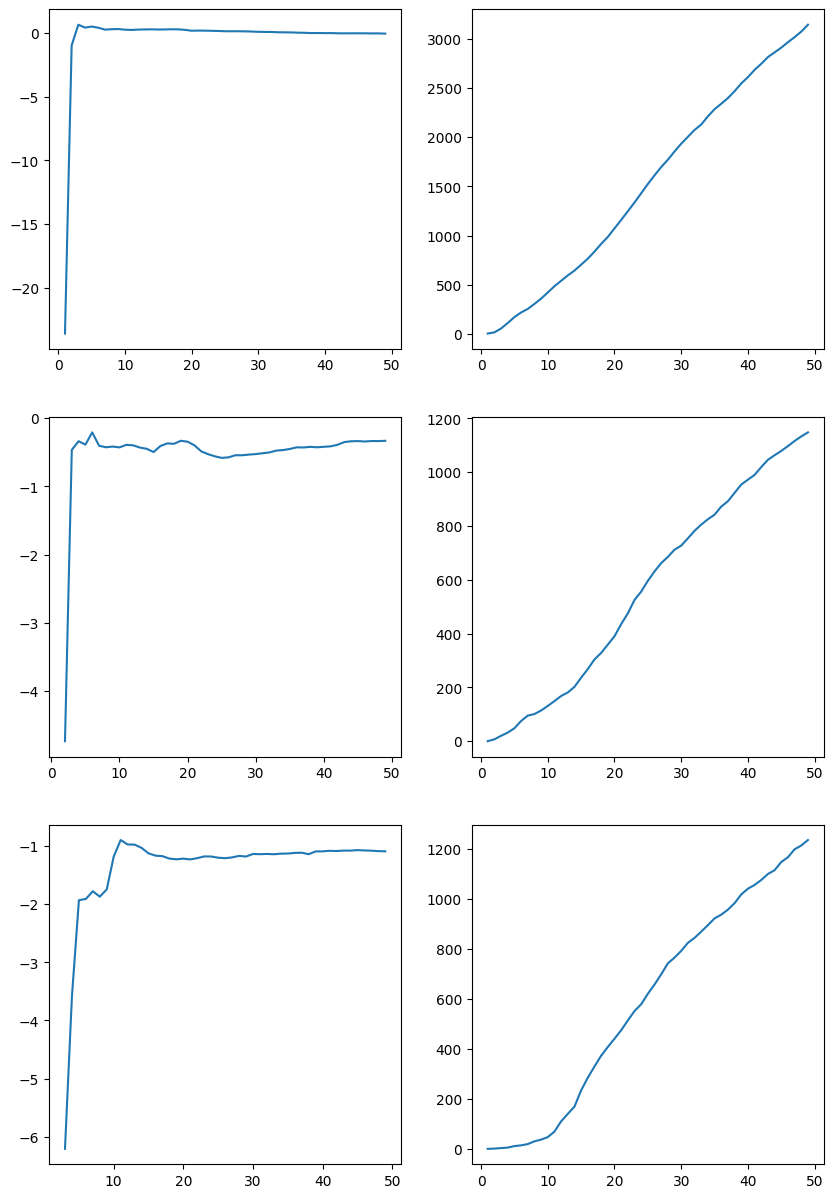

In [13]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [14]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [15]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.76839189].         R squared is : 0.44222642240739196.
The error for coeff = 1 is: 0.20126103832761366.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.15712977].         R squared is : 0.04842290946295491.
The error for coeff = 1 is: -0.5046095812411413.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.00444276].         R squared is : 0.0003372850982684694.
The error for coeff = 1 is: -1.1809920065890869.


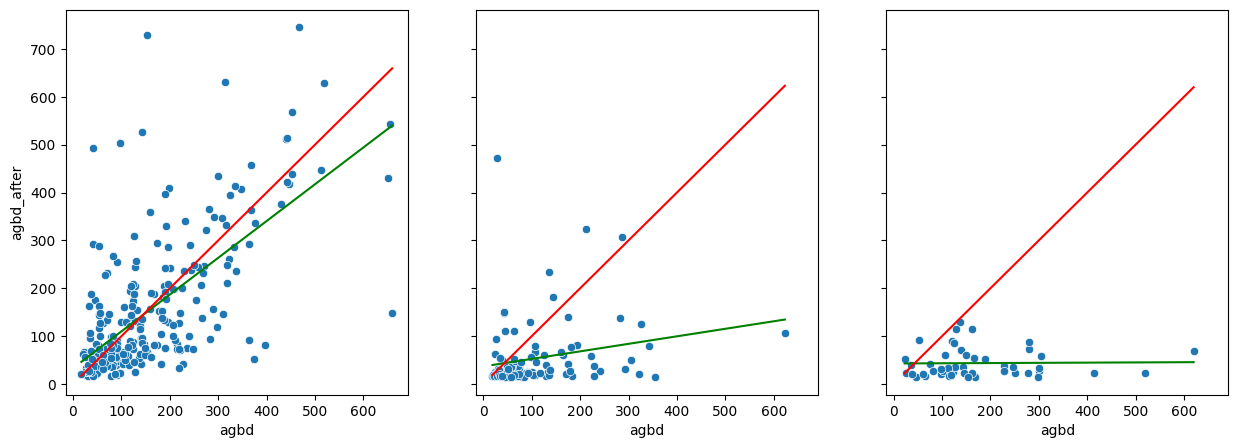

In [16]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

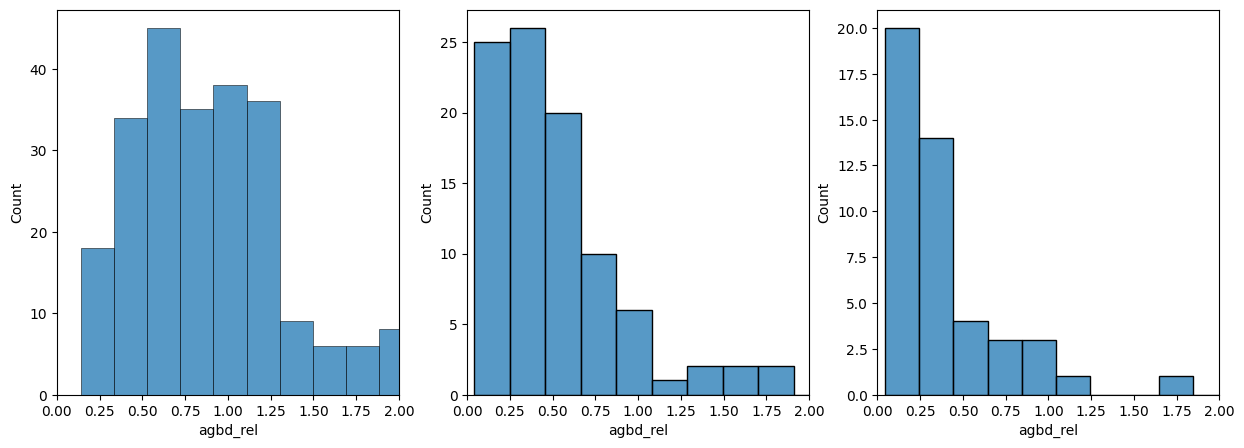

In [17]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

A lot of low severity seems misclassified.

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000112  1982.625715 -3788.142800     inf      0.134649   
norm            0.000115  1970.547520 -3792.245461     inf      0.144065   
lognorm         0.000116  1974.466898 -3785.635763     inf      0.147313   
gamma           0.000321  1461.320120 -3520.753736     inf      0.355815   
burr            0.000646  1774.420676 -3333.311970     inf      0.683984   

             ks_pvalue  
beta      1.426453e-04  
norm      3.582149e-05  
lognorm   2.175695e-05  
gamma     5.817213e-30  
burr     2.202453e-121  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'norm': {'loc': 2.4369560755216155, 'scale': 108.73022381493232}}


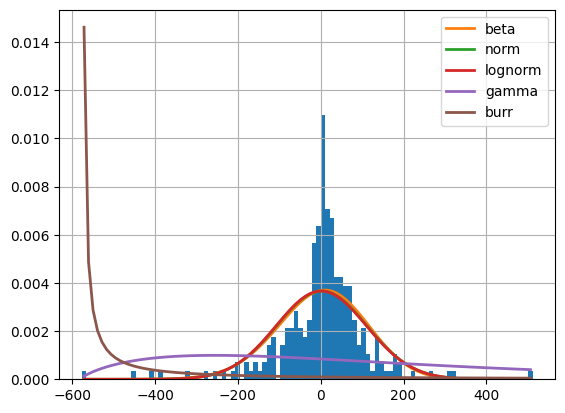

In [18]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000272  1807.633527 -1262.959142     inf      0.167440   
gamma           0.000272  1803.560079 -1267.490932     inf      0.173149   
norm            0.000274  1796.346072 -1271.531678     inf      0.164724   
lognorm         0.000831  1786.937967 -1155.947274     inf      0.794566   
burr            0.000883  1752.080294 -1145.321754     inf      0.702958   

            ks_pvalue  
beta     6.413351e-03  
gamma    4.311928e-03  
norm     7.710207e-03  
lognorm  3.923730e-68  
burr     3.871696e-50  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

{'norm': {'loc': 54.37489471435547, 'scale': 106.96003525491984}}


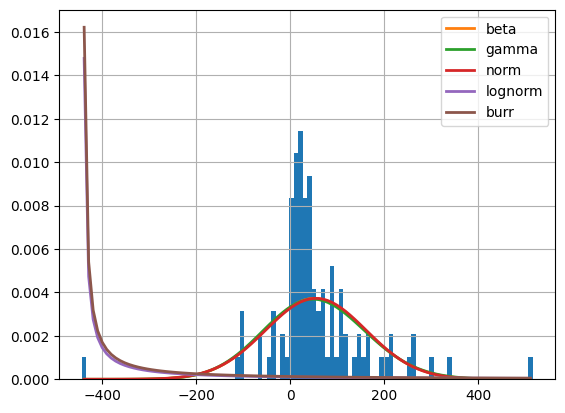

In [19]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma           0.000464  1398.153034 -530.151665     inf      0.065442   
beta            0.000464  1399.943441 -526.294431     inf      0.065120   
norm            0.000534  1441.930547 -527.378116     inf      0.151840   
lognorm         0.001630  1678.831472 -471.094045     inf      0.699866   
burr            0.001739  1618.662475 -464.218613     inf      0.535917   

            ks_pvalue  
gamma    9.799540e-01  
beta     9.809021e-01  
norm     2.064718e-01  
lognorm  1.342721e-23  
burr     3.806278e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

{'norm': {'loc': 129.4534209839841, 'scale': 124.69034455144067}}


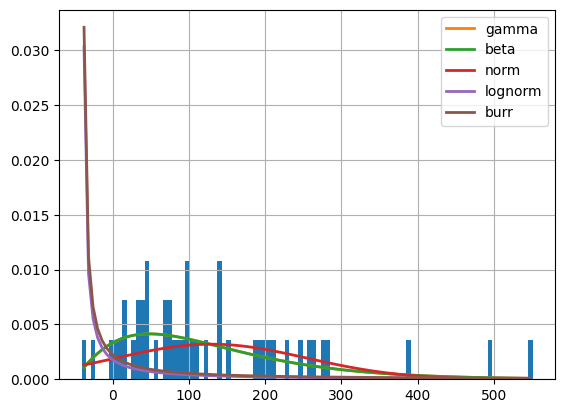

In [20]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [21]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8795669078826904, pvalue=1.8078090023229687e-13)
Ttest results: TtestResult(statistic=0.36070096269246793, pvalue=0.7186170141675108, df=259)
Wilcoxon test results: WilcoxonResult(statistic=14547.0, pvalue=0.04634751218737901)


In [22]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8515157699584961, pvalue=1.3496331163764808e-08)
Ttest results: TtestResult(statistic=5.05818243289054, pvalue=1.94897952072958e-06, df=99)
Wilcoxon test results: WilcoxonResult(statistic=767.0, pvalue=1.4980428707088134e-09)


In [23]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8745905756950378, pvalue=0.0001224538718815893)
Ttest results: TtestResult(statistic=7.041409835832142, pvalue=7.898174912656163e-09, df=46)
Wilcoxon test results: WilcoxonResult(statistic=19.0, pvalue=4.362732397567015e-12)


## PAI Analysis

In [24]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(creek_fire, gedi_burned_l2b, 'pai')

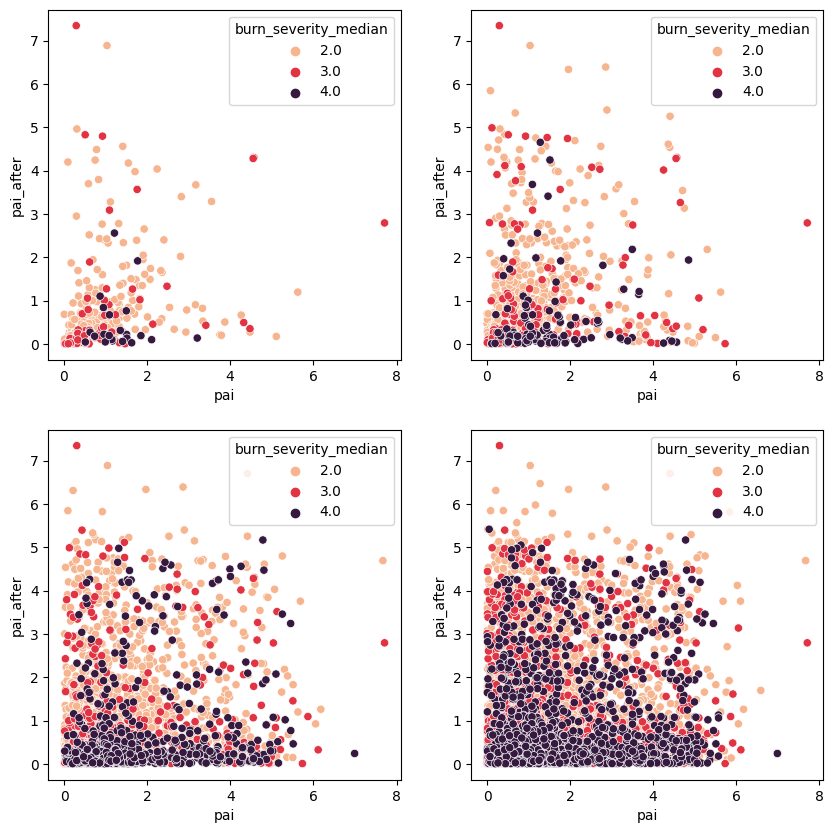

In [25]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai')

In [26]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

In [27]:
close_matches = l2b_filter_land_cover(matches_l2b[matches_l2b.closest_distance < 10])

In [28]:
close_matches['date_since'] = ((close_matches.match_datetime - creek_fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.26137564].         R squared is : 0.04560364966033659.
The error for coeff = 1 is: -0.9753616484134036.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.14641204].         R squared is : 0.022174614170272.
The error for coeff = 1 is: -0.7681004393928514.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.01433071].         R squared is : 0.00028793567526719244.
The error for coeff = 1 is: -1.467468289595065.


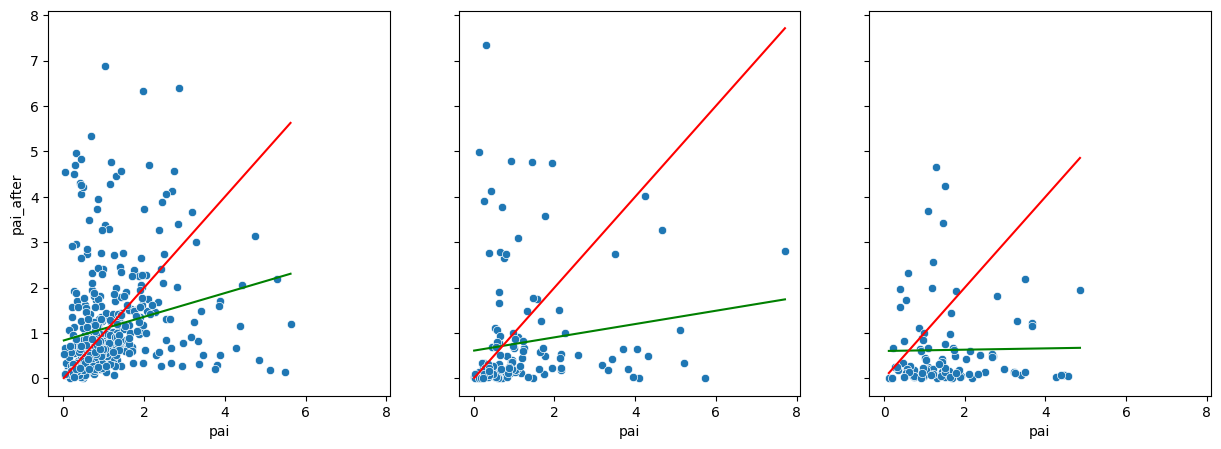

In [29]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'pai')

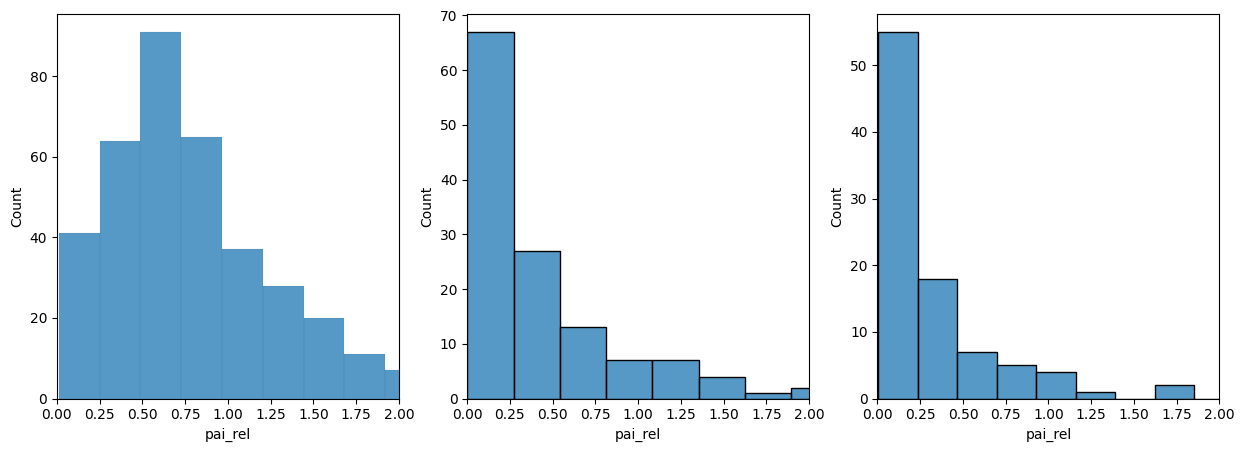

In [30]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


         sumsquare_error         aic          bic  kl_div  ks_statistic  \
burr            0.983498  883.221381 -2597.399860     inf      0.117139   
beta            1.653425  855.161758 -2373.500215     inf      0.167455   
lognorm         1.659292  854.974952 -2378.039685     inf      0.171536   
norm            1.659695  850.123485 -2384.001243     inf      0.169556   
gamma           1.727788  836.186869 -2360.605453     inf      0.182837   

            ks_pvalue  
burr     1.309363e-05  
beta     4.939298e-11  
lognorm  1.472625e-11  
norm     2.659050e-11  
gamma    4.413030e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

{'norm': {'loc': 0.006490790093967512, 'scale': 1.3161461805770573}}


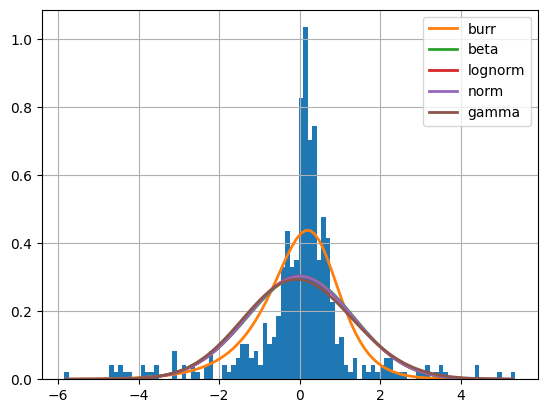

In [31]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
lognorm         1.972267  825.217268 -608.214567     inf      0.217914   
beta            1.976767  796.388300 -602.907337     inf      0.208176   
norm            1.978997  813.307995 -612.697348     inf      0.216372   
gamma           2.013210  824.138943 -605.235293     inf      0.229745   
burr            2.413369  842.384123 -573.971041     inf      0.277678   

            ks_pvalue  
lognorm  1.588505e-06  
beta     5.452549e-06  
norm     1.938742e-06  
gamma    3.280500e-07  
burr     2.236977e-10  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

{'norm': {'loc': 0.39843356930827584, 'scale': 1.6794497998020281}}


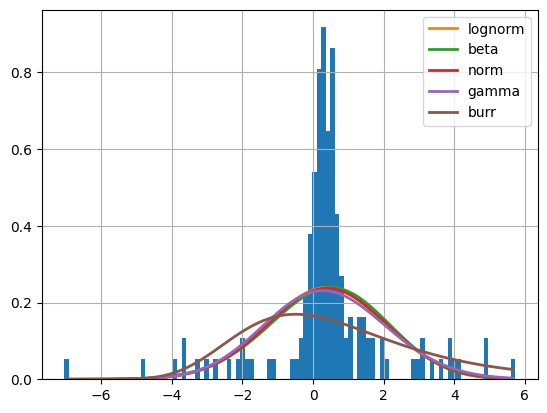

In [32]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
burr            1.728868  545.914557 -397.405720     inf      0.075715   
lognorm         1.918654  531.928044 -391.406671     inf      0.106631   
norm            1.922440  527.606099 -395.830544     inf      0.106691   
beta            1.925960  528.697752 -386.394018     inf      0.104304   
gamma           1.931306  530.736940 -390.736247     inf      0.111065   

         ks_pvalue  
burr      0.576109  
lognorm   0.182837  
norm      0.182354  
beta      0.202411  
gamma     0.149668  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


{'norm': {'loc': 0.9532405669803922, 'scale': 1.3983012650295326}}


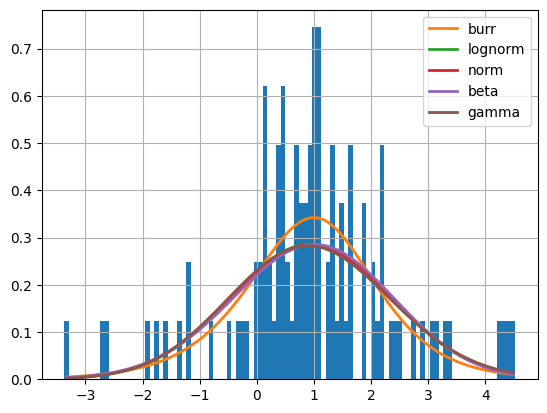

In [33]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'pai')

## PAI Z Analysis

In [38]:
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

<module 'src.data.pai_vertical' from '/home/jk871/fire-regen/src/data/pai_vertical.py'>

In [39]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(creek_fire, gedi_burned_l2b)

In [40]:
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 10])

In [43]:
def get_pai_z_df(df, severity):
    lala = get_severity(close_matches, severity).pai_z_delta_np_diff.to_numpy()
    new_lala = np.empty((lala.shape[0], lala[0].shape[0]))

    for i in range(lala.shape[0]):
        new_lala[i] = lala[i]

    return pd.melt(pd.DataFrame(new_lala))

(0.0, 13.0)

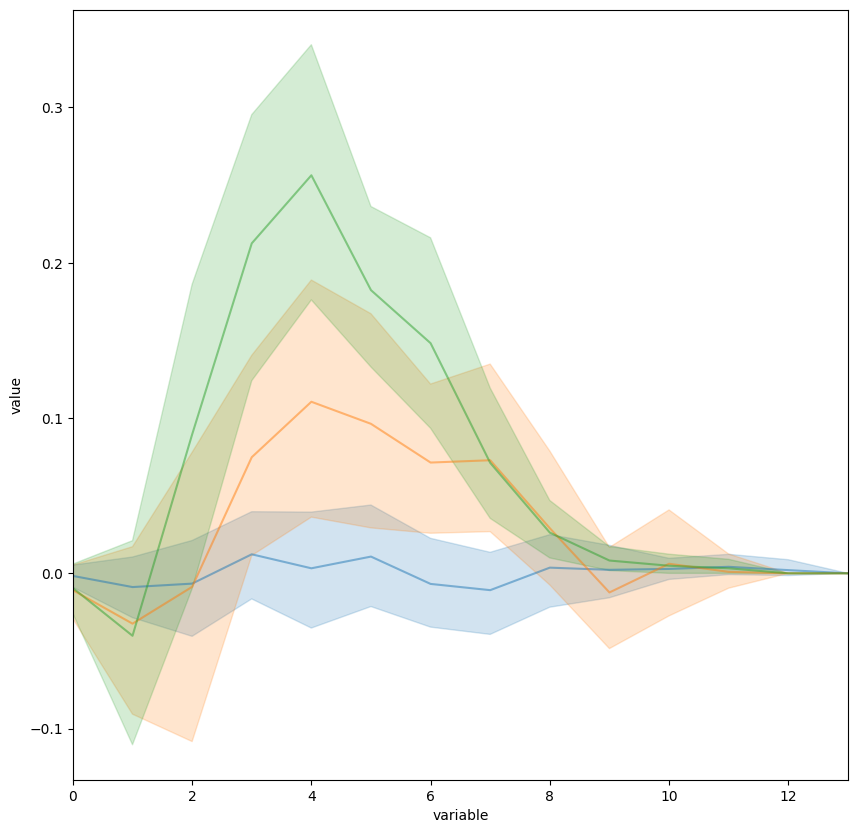

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(close_matches, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))

In [256]:
close_matches['date_since'] = ((close_matches.match_datetime - creek_fire.cont_date)/np.timedelta64(1, 'M')).astype(int)